Технический ноутбук к экспериментами по сравнению двух моделей. Хочется: подаёшь в модуль 2 модели, а он печатает табличку сравнения, графики строит, какие-то детали выводит.

status: in progress

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from IPython.display import display, HTML

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths

import create_model_helper as cmh
import test_vs_original_columns_helper as tvsoch
import distances_helper as dh
import build_convex_hull_helper as bchh
import print_helper as ph
import compare_two_models as ctm

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
plot_maker = PlotMaker()
print config.models_file_name

models_file = open(config.models_file_name, 'a')

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_compare_models_tmp\models.txt


Creating syntetic models (3):

In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file

def create_syntetic_model_1(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m1__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model
def create_syntetic_model_2(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m2__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model
def create_syntetic_model_3(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m3__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model


def create_model_fn_20_reg_8(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer'].tau = -20
    tmp_model.regularizers['ss_phi_regularizer'].tau = -20
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = -10 
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20,             
                                  _model_name='model_20_reg_8_iter_{}'.format(n_iteration))
    return tmp_model
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def get_not_diagonal_flatten_values(mat):
    not_diagonal_values = []
    for row_ind, row in enumerate(mat):
        for col_ind, val in enumerate(row):
            if row_ind != col_ind:
                not_diagonal_values.append(val)
    return not_diagonal_values
def plot_different_distances(different_distances):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    vals = different_distances[dh.kl_dist].values.flatten()
    sns.distplot(vals, color='y', ax=ax1, label='kl')
    vals = different_distances[dh.kl_sym_dist].values.flatten()
    sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()
def plot_different_opt_fun(different_opt_results):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))    
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.jaccard_dist].iteritems()]
    sns.distplot(opt_fun_values, color='r', ax=ax1, label='jaccard')
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.cos_dist].iteritems()]    
    sns.distplot(opt_fun_values,  color='b', ax=ax1, label='cos')
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.hellinger_dist].iteritems()]   
    sns.distplot(opt_fun_values, color='g', ax=ax1, label='hellinger')
    
    if dh.kl_dist in different_opt_results.keys():
        opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.kl_dist].iteritems()]   
        sns.distplot(opt_fun_values, color='y', ax=ax3, label='kl')
    if dh.kl_sym_dist in different_opt_results.keys():    
        opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.kl_sym_dist].iteritems()]   
        sns.distplot(opt_fun_values, color='m', ax=ax3, label='kl_sym')    
    ax1.legend()
    ax2.legend()
def print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_results, different_distances):
    def print_single_distance1(different_opt_results, dist_fn):
        print dist_fn, "===================================================="
        if dist_fn in different_opt_results.keys():
            for topic, opt_res in different_opt_results[dist_fn].iteritems():
                coeff_col_name = sorted(zip(opt_res['x'], opt_res['column_names']))[::-1][0][1]
                closest_col_dist = different_distances[dist_fn].loc[coeff_col_name, :].sort_values()[1:2]
                print 'Opt_topic =', topic, opt_res['fun'], ', first x coeff = ', \
                    coeff_col_name, closest_col_dist[0], 'to', closest_col_dist.index[0]
    def print_single_distance(different_opt_results, dist_fn):
        print dist_fn, "===================================================="
        if dist_fn in different_opt_results.keys():
            for topic, opt_res in different_opt_results[dist_fn].iteritems():
                closest_col_dist = different_distances[dist_fn].loc[topic, :].sort_values()[1:2]
                print 'Opt_topic =', topic, opt_res['fun'], ', closest topic =', \
                    closest_col_dist.index[0], closest_col_dist[0]
    print_single_distance(different_opt_results, dh.jaccard_dist)
    print_single_distance(different_opt_results, dh.cos_dist)
    print_single_distance(different_opt_results, dh.hellinger_dist)
    print_single_distance(different_opt_results, dh.kl_dist)
    print_single_distance(different_opt_results, dh.kl_sym_dist)
def check_topic_correctness(topic_phi, topic_theta=[], _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if len(topic_theta):
        # topic must have at least one doc, assigned to it
        topic_theta = topic_theta.values
        topic_docs_count_rule = len(topic_theta[np.where(topic_theta != 0)[0]]) >= 1
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

Загрузим original фи и тету. Создадим какую-нибудь тестовую фи и тету. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)

test_model = create_model_fn_20_reg_8(0)
phi_test, theta_test = test_model.get_phi(), test_model.get_theta()

name = model_20_reg_8_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -20
decorrelator_phi_regularizer, tau = -10
ss_phi_regularizer, tau = -20



### Тop words

In [5]:
ph.print_phi_top_tokens(phi_original, phi_test)


------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019 костюм: 0.018 реализация: 0.018
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 0.019 грамматика: 0.017 тип: 0.016 смысл: 0.014 существительное: 0.014 пример: 0.013 лингвист: 0.013
topic_2 | молекула: 0.150 белка: 0.116 белок: 0.092 вирус: 0.066 рецептор: 0.055 опухоль: 0.035 нобелевский_премия: 0.027 клетка: 0.026 образ: 0.025 взаимодействие: 0.023 аминокислота: 0.020 работа: 0.019 ранний_вселенная: 0.017 обновление: 0.015 структура: 0.015
topic_3 | работа: 0.165 статья: 0.097 автор: 0.078 журнал: 0.075 исследование: 0.051 публикация: 0.039 раздел: 0.033 тема: 0.032 вопр

### Поиск ближайшей колонки, не равной самой себе

Dist fn = <function kl_dist at 0x000000000BBC2748>, Processed th = 100, original columns count = 20    = 20    

C:\Users\Sheldon\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:2498: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=0)
C:\Users\Sheldon\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:2491: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


Dist fn = <function kl_sym_dist at 0x000000000BC68438>, Processed th = 100, original columns count = 20    

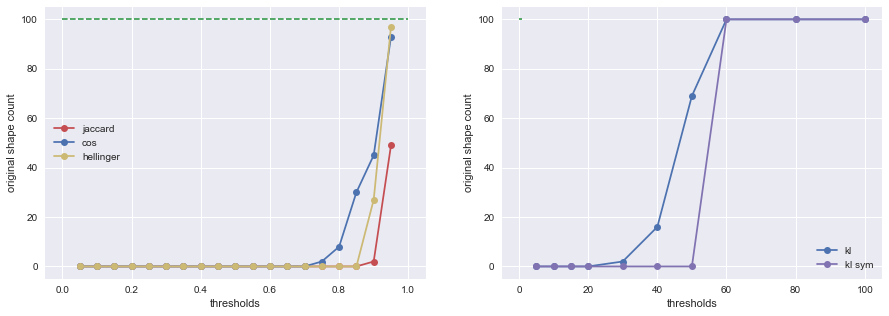

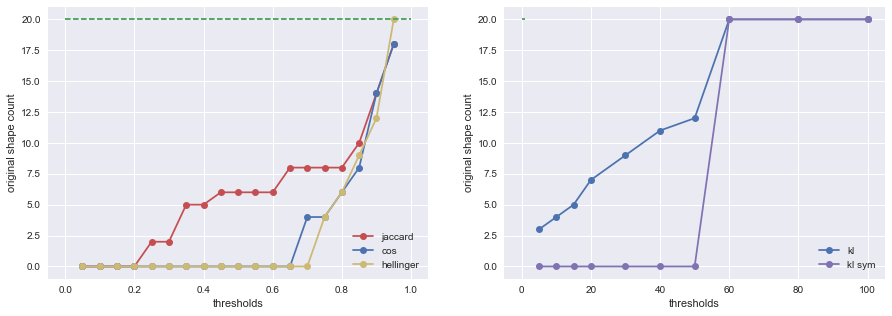

In [6]:
% matplotlib inline
different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, n_original_columns_count=phi_original.shape[1])
different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, n_original_columns_count=phi_test.shape[1])

C:\Users\Sheldon\Anaconda2\lib\site-packages\seaborn\utils.py:365: RuntimeWarning: invalid value encountered in double_scalars
  return q3 - q1


ValueError: cannot convert float NaN to integer

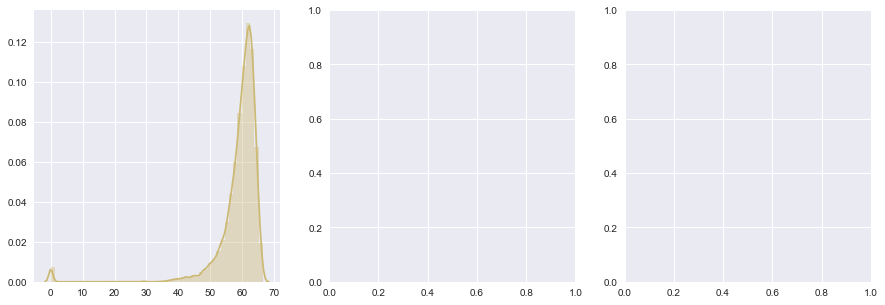

In [7]:
% matplotlib inline
different_inter_distances_1 = get_distances(phi_original)
plot_different_distances(different_inter_distances_1)

different_inter_distances_2 = get_distances(phi_test)
plot_different_distances(different_inter_distances_2)

### project to original (one to one and opt)

Dist fn = <function kl_sym_dist at 0x000000000BC68438>, Processed th = 100, original columns count = 20        

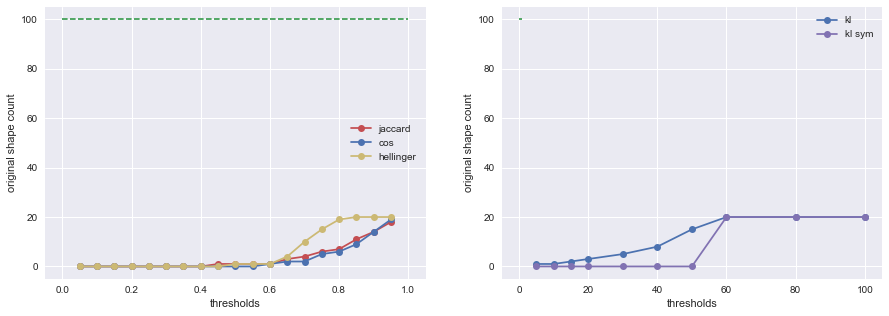

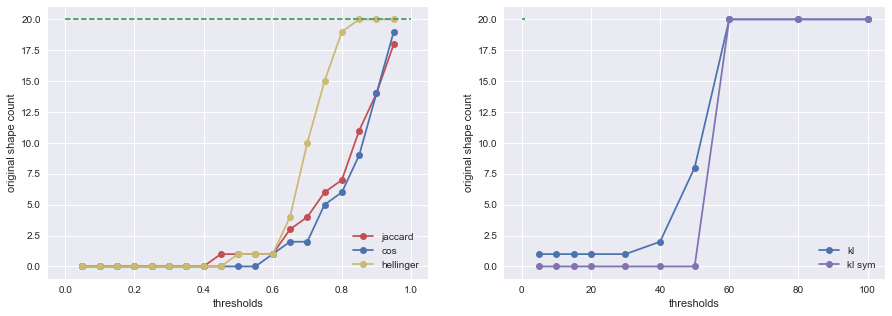

In [8]:
% matplotlib inline
different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, n_original_columns_count=phi_original.shape[1])
different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, n_original_columns_count=phi_test.shape[1])

Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.05, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.1, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.15, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.2, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.25, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.3, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.35, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.4, original columns count = 0    
Dist fn = <function jaccard_dist at 0x000000000BCBE588>, Processed th = 0.45, original columns count = 0    
Dist fn = <function jac

C:\Users\Sheldon\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:2491: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
C:\Users\Sheldon\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:2498: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=0)
C:\Users\Sheldon\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon


Column topic_0 not optimized
Column topic_1 not optimized
Column topic_2 not optimized
Column topic_3 not optimized
Column topic_4 not optimized
Column topic_5 not optimized
Column topic_6 not optimized
Column topic_7 not optimized
Column topic_8 not optimized
Column topic_9 not optimized
Column topic_10 not optimized
Column topic_11 not optimized
Column topic_12 not optimized
Column topic_13 not optimized
Column topic_14 not optimized
Column topic_15 not optimized
Column topic_16 not optimized
Column topic_17 not optimized
Column topic_18 not optimized
Column topic_19 not optimized
Dist fn = <function kl_sym_dist at 0x000000000BCBE518>, Processed th = 5, original columns count = 0    
Dist fn = <function kl_sym_dist at 0x000000000BCBE518>, Processed th = 10, original columns count = 0    
Dist fn = <function kl_sym_dist at 0x000000000BCBE518>, Processed th = 15, original columns count = 0    
Dist fn = <function kl_sym_dist at 0x000000000BCBE518>, Processed th = 20, original columns c

IndexError: index 20 is out of bounds for axis 0 with size 20

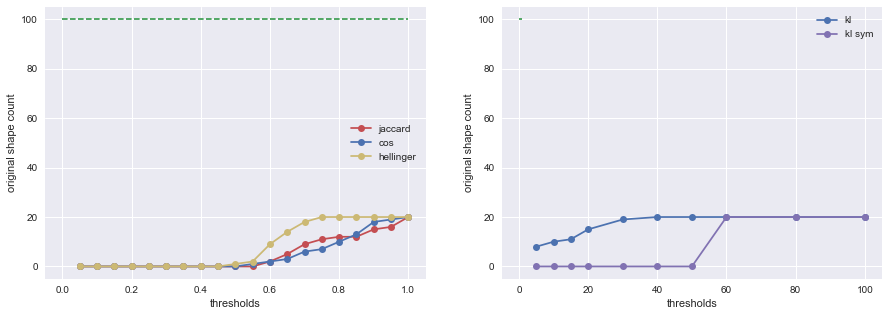

In [5]:
% matplotlib inline
different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original)
tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, n_original_columns_count=phi_original.shape[1])
different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test)
tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, n_original_columns_count=phi_test.shape[1])

Порог немного меньше, чем при one to one без convex hull. 

Выведем phi_test_column, closest by opt original column, dist.

In [10]:
different_to_original_opts_1[dh.cos_dist][1][1]

[(u'topic_0', u'topic_17', 0, 17, 0.89470163044137319),
 (u'topic_1', u'topic_16', 1, 16, 0.66276647886767459),
 (u'topic_2', u'topic_15', 2, 15, 0.8540089644156269),
 (u'topic_3', u'topic_14', 3, 14, 0.88196323526230036),
 (u'topic_4', u'topic_13', 4, 13, 0.55728469095749111),
 (u'topic_5', u'topic_12', 5, 12, 0.78963213623634498),
 (u'topic_6', u'topic_11', 6, 11, 0.7927231647795423),
 (u'topic_7', u'topic_10', 7, 10, 0.67739386212614661),
 (u'topic_8', u'topic_19', 8, 19, 0.89775550106471214),
 (u'topic_9', u'topic_18', 9, 18, 0.79935081942290931),
 (u'topic_10', u'topic_5', 10, 5, 0.84370420910272048),
 (u'topic_11', u'topic_4', 11, 4, 1.0),
 (u'topic_12', u'topic_3', 12, 3, 0.51984095639331296),
 (u'topic_13', u'topic_2', 13, 2, 0.67073224962845446),
 (u'topic_14', u'topic_9', 14, 9, 0.63759786134687113),
 (u'topic_15', u'topic_8', 15, 8, 0.70589328268919416),
 (u'topic_16', u'topic_7', 16, 7, 0.81419040764205153),
 (u'topic_17', u'topic_6', 17, 6, 0.84861455614209269),
 (u'topic_

# Сравнительные характеристики

In [11]:
models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test)

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,20.00
non zero ratio,0.96,0.99
|phi_ij == 0| / n_topics,2126.43,2183.60
|phi_ij > 0.2| / n_topics,0.23,0.70
|phi_ij > 0.1| / n_topics,0.89,1.70
|phi_ij > 0.01| / n_topics,27.16,14.70
|phi_ij > 0.05| / n_topics,2.63,3.90
|phi_ij > 0.001| / n_topics,80.26,31.25


# using bigartm
спросить можно ли как-то их вытащить

In [160]:
tm_model = cmh.create_model(current_dictionary=dictionary, n_topics=phi_test.shape[1], n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
(_, phi_ref) = tm_model.master.attach_model(model=tm_model.model_pwt)

for model_description in tm_model.info.model:
    print model_description
np.copyto(phi_ref, phi_test.values) 
# transform
theta_test = tm_model.transform(batch_vectorizer=batch_vectorizer)

tm_model.score_tracker

name: "nwt"
type: "class artm::core::DensePhiMatrix"
num_topics: 20
num_tokens: 2216

name: "pwt"
type: "class artm::core::AttachedPhiMatrix"
num_topics: 20
num_tokens: 2216



{}

# inter opt res for different dists

In [17]:
N_CLOSEST_TOPICS = 20
def get_different_opt_res(phi, different_distances):
    different_opts = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist]#, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        print 'Processing =', dist_fn
        different_opts[dist_fn] = bchh.get_optimization_result_one_matrix(dist_fn, None, phi, different_distances[dist_fn],
                                       [], N_CLOSEST_TOPICS, _debug_print=False)
    return different_opts

In [18]:
different_opt_res_phi1 = get_different_opt_res(phi1, different_distances1)
save_pickle_file(different_opt_res_phi1, 'different_opt_res_phi1.p')

Processing = <function jaccard_dist at 0x000000000BF344A8>
Processing = <function cos_dist at 0x000000000BF34588>
Processing = <function hellinger_dist at 0x000000000BF345F8>


In [21]:
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    col_val = col.copy()
    if cut_th != None:
        col_val[col_val < cut_th] = 0
    for val in col_val.sort_values()[::-1]:
        if val != 0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    cut_th_x, cut_th_probs = 5*1e-2, 1e-3
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=cut_th_x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_th = [get_words_close_to_th_count(col, cut_th=cut_th_probs)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    sns.distplot(grans_th, color='b', bins=5, ax=ax4)
    title = '{} {} \nx_count_grans_mean = {}; x_count_grans_mean_th={}\nth={}'.\
        format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th, cut_th_x)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)
    title = '{} {} \ngrans_mean_th = {}, cut_th={}'.format(name, phi.shape, np.mean(grans_th), cut_th_probs)
    ax4.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean



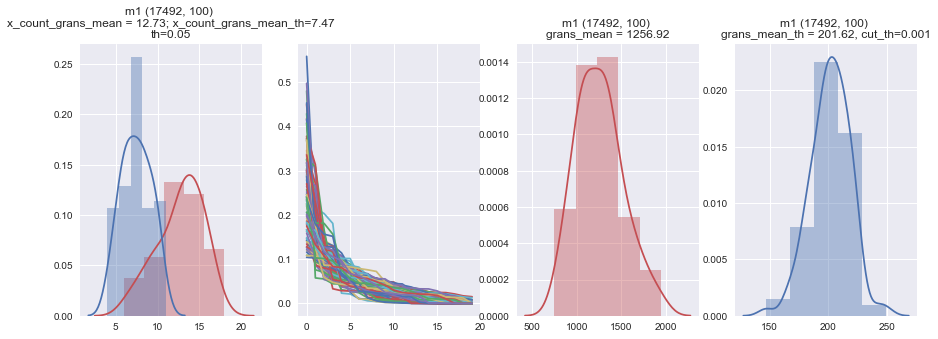

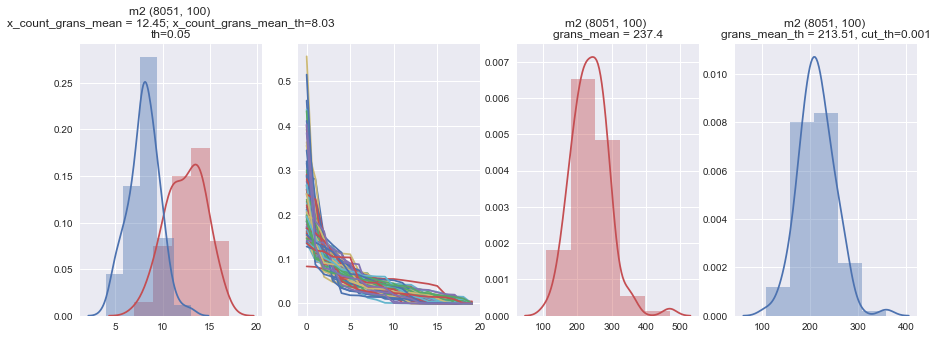

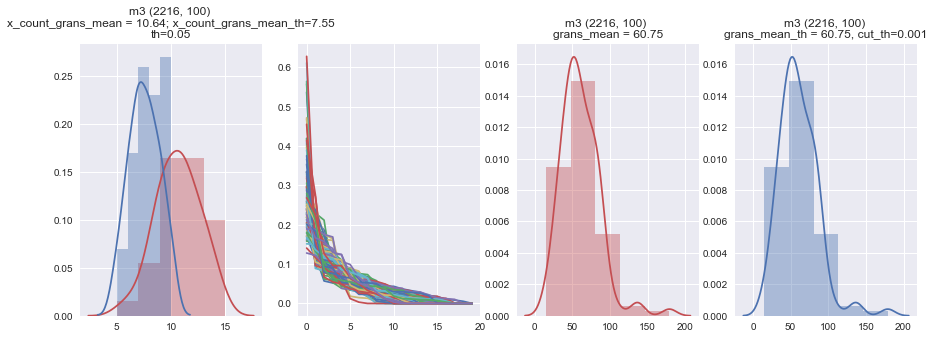

In [22]:
_,_,_,_ = get_and_plot_granularity(phi1, different_opt_res_phi1[dh.hellinger_dist], 'm1')
_,_,_,_ = get_and_plot_granularity(phi2, different_opt_res_phi2[dh.hellinger_dist], 'm2')
_,_,_,_ = get_and_plot_granularity(phi3, different_opt_res_phi3[dh.hellinger_dist], 'm3')

Посмотрим, а как близко найденная л/к в опт приближала колонки (opt_fun) распределение. И на каком расстоянии находится ближайшая колонка.

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


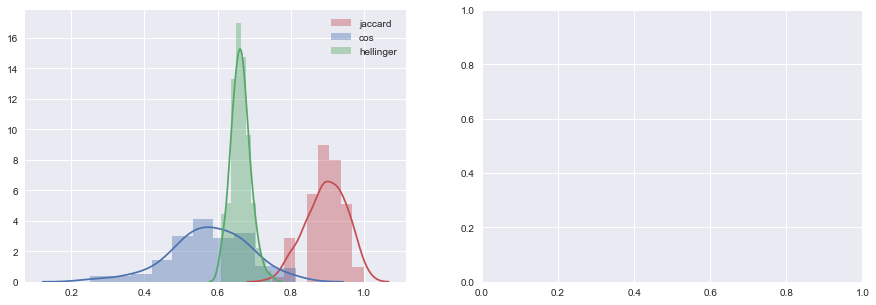

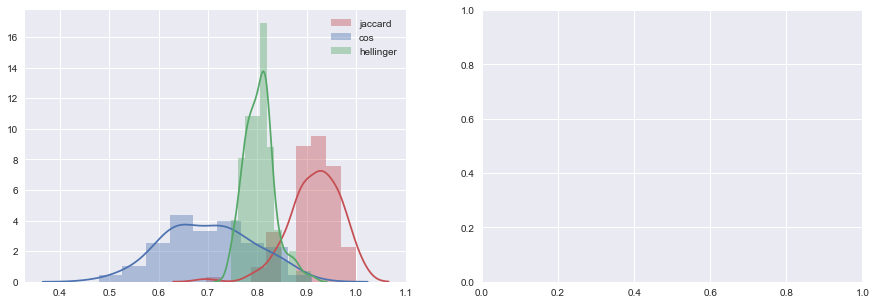

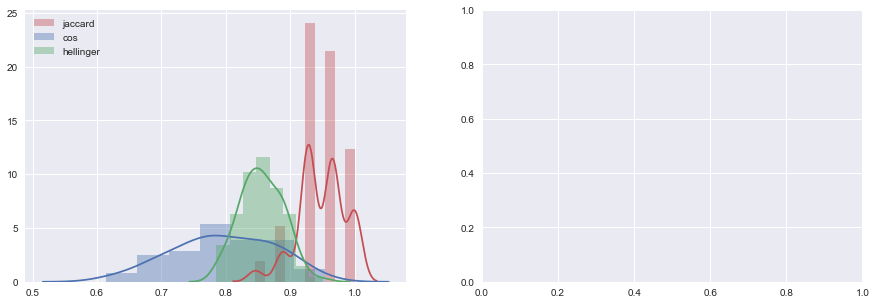

In [26]:
%matplotlib inline
plot_different_opt_fun(different_opt_res_phi1)
plot_different_opt_fun(different_opt_res_phi2)
plot_different_opt_fun(different_opt_res_phi3)

In [27]:
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi1, different_distances1)
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi2, different_distances2)
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi3, different_distances3)

<function jaccard_dist at 0x000000000BF344A8> ====================================================
Opt_topic = topic_68 0.965517241379 , closest topic = topic_65 0.888888888889
Opt_topic = topic_69 0.888888888889 , closest topic = topic_58 0.928571428571
Opt_topic = topic_62 0.8 , closest topic = topic_91 0.888888888889
Opt_topic = topic_63 0.888888888889 , closest topic = topic_10 0.928571428571
Opt_topic = topic_60 0.928571428571 , closest topic = topic_49 0.928571428571
Opt_topic = topic_61 0.846153846154 , closest topic = topic_5 0.888888888889
Opt_topic = topic_66 0.888888888889 , closest topic = topic_78 0.888888888889
Opt_topic = topic_67 0.928571428571 , closest topic = topic_34 0.888888888889
Opt_topic = topic_64 0.846153846154 , closest topic = topic_2 0.75
Opt_topic = topic_65 0.888888888889 , closest topic = topic_87 0.888888888889
Opt_topic = topic_79 0.846153846154 , closest topic = topic_16 0.888888888889
Opt_topic = topic_78 0.928571428571 , closest topic = topic_71 0.8

In [9]:
dh.jaccard_dist(phi1.iloc[:,1], phi1.iloc[:,1])

0.0

Видно, что opt_fun (расстояние от найденной оптимальной л/к) ближе, чем просто поиск ближайшей колонки. Но, кстати, не всегда (только topic_68 ?)  .todo: check

* расхождения с avg kernel size?
* проверить kl opt